In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch
from storage.query_storage import QueryStorage
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
from collections import OrderedDict

enc_len = 50
num_actions = 21
mol_enc =   OrderedDict([('A', 0), ('R', 1), ('N', 2), ('D', 3), ('C', 4), ('E', 5), ('Q', 6), ('G', 7), ('H', 8), ('I', 9), ('L', 10), ('K', 11), ('M', 12), ('F', 13), ('P', 14), ('S', 15), ('T', 16), ('W', 17), ('Y', 18), ('V', 19), ('>', 20)])

def seq_to_enc(seq):
    enc = [None for i in range(enc_len)]
    for i in range(enc_len):
        if i < len(seq):
            enc[i] = mol_enc[seq[i]]
        else:
            enc[i] = 20
    
    return F.one_hot(torch.tensor(enc), num_classes=num_actions).numpy()

def get_AMP_data(mode):

    if mode == "test":
        df = pd.read_csv("data/210820_v0.24.1_rf_not-alibicani.csv")
    elif mode == "val":
        df = pd.read_csv("data/210820_v0.24.1_rf_alibicani.csv")
    else:
        raise NotImplementedError
 
#     df = df[(df.sequence.map(len) >= 15)]
    filtered_seq = df.sequence.map(lambda x : 'C' not in x and len(x) >= 15 and len(x) <= 50)
    df = df[filtered_seq]
    
    df.sequence = df.sequence.map(seq_to_enc)

    storage = QueryStorage(df.sequence.shape[0], df.sequence.shape[1:])

    storage.mols = torch.tensor(df.sequence.to_list())

    storage.scores = torch.tensor(df.is_amp.to_list()).long()

    return storage




In [2]:
# df = pd.read_csv("data/210820_v0.24.1_rf_alibicani.csv")


In [3]:
data = get_AMP_data("test")

In [4]:
data.mols.shape

torch.Size([22060, 50, 21])

In [5]:
seq = data.mols.flatten(start_dim=-2, end_dim=-1)
value = data.scores

In [7]:
import random
from tqdm import tqdm

num_seeds = 10
scores = []


for s in tqdm(range(num_seeds)):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(random_state=s, n_estimators=128)
    model.fit(seq, value)
    
    max_scores = []

    for qq in range(8):
        mol_probs = []
        mols = []
        for i in range(250):
            rand_len = random.randint(1, 50)

            rand_mol = [random.randint(0, 19) for i in range(rand_len)]
            rand_mol += (50 - len(rand_mol))*[20]
            rand_mol = torch.tensor(rand_mol)
            rand_mol = torch.nn.functional.one_hot(rand_mol, num_classes=21).flatten(-2, -1)
            mols.append(rand_mol)


        mol_probs = model.predict_proba(torch.stack(mols, 0).numpy())
        
        mol_probs = mol_probs[:, 1]

#         print("Average score:", mol_probs.mean())

#         print("Cumulative Max Score:", mol_probs.max())


        max_scores.append(mol_probs.max())



    scores.append(max_scores)

 10%|█         | 1/10 [00:19<02:54, 19.40s/it]


KeyboardInterrupt: 

In [49]:
print("Cumul. max scores", max_scores)

Cumul. max scores [0.2734375, 0.2578125, 0.2265625, 0.28125, 0.375, 0.2890625, 0.3984375, 0.2578125]


In [50]:
for i in range(num_seeds):
    for j in range(1, 8):
        scores[i][j] = max(scores[i][j], scores[i][j-1])

In [51]:
ys = np.array(scores)

In [52]:
y_mean = ys.mean(0)
y_std = ys.std(0)/num_seeds**0.5

In [53]:
xs = [250*i for i in range(1, 9)]

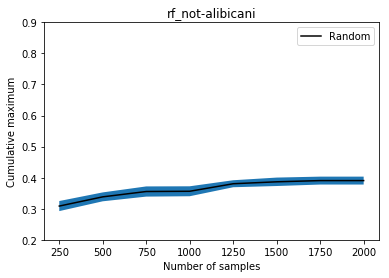

In [54]:
plt.ylim((0.2, 0.9))
plt.title("rf_not-alibicani")
plt.plot(xs, y_mean, 'k-', label='Random')
plt.fill_between(xs, y_mean-y_std, y_mean+y_std)
plt.xlabel("Number of samples")
plt.ylabel("Cumulative maximum")
plt.legend()
plt.show()

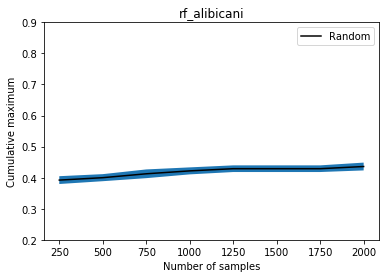

In [44]:
plt.ylim((0.2, 0.9))
plt.title("rf_alibicani")
plt.plot(xs, y_mean, 'k-', label='Random')
plt.fill_between(xs, y_mean-y_std, y_mean+y_std)
plt.xlabel("Number of samples")
plt.ylabel("Cumulative maximum")
plt.legend()
plt.show()

In [13]:
sklearn.__version__

'0.24.1'

## Using the AMP dataset

In [235]:
df = pd.read_csv('./data/amp_dataset.csv')
# df = pd.read_csv('./data/amp_dataset_cleaned_apparently.csv')

In [236]:
df_2 = pd.read_csv('./data/amp_dataset_2.csv')

In [237]:
df_2

,target,sequence,value,is_amp
0,A. acidoterrestris,FWQKMSFA,1.345238,True
1,A. actinomycetemcomitans,FKCRRWQWRMKKLGKRSKNKGFKEQAKSLLKWILD,0.707570,True
2,A. actinomycetemcomitans,GIGDPVTCLKSGAICHPVFCPRRYKQIGTCGLPGTKCCKKP,1.761030,True
3,A. actinomycetemcomitans,GVVDILKGAAKDIAGHLASKVM,2.347076,True
4,A. actinomycetemcomitans,GVVDILKGAAKDIAGHLASKVMN,2.322302,True
...,...,...,...,...
115911,Z. mobilis,RCATCARPFF,4.000000,False
115912,Z. mobilis,GKGLHEFDSL,4.000000,False
115913,Z. mobilis,EELACVNDIV,4.000000,False
115914,Z. mobilis,DGQHLASGDR,4.000000,False


In [238]:
(df == df_2).sum()

target      115916
sequence    115916
value       115916
is_amp      115916
dtype: int64

In [239]:
df.target.unique()

array(['A. acidoterrestris', 'A. actinomycetemcomitans', 'A. alternata',
       'A. awamori', 'A. baumanii', 'A. baumannii', 'A. brasiliensis',
       'A. brassicae', 'A. brassicicola', 'A. brassicola',
       'A. calcoaceticus', 'A. carrageenovora', 'A. caviae', 'A. cinerea',
       'A. dauci', 'A. faecalis', 'A. favus', 'A. fla', 'A. flavus',
       'A. fumigates', 'A. fumigatus', 'A. globiformis', 'A. helianthi',
       'A. hydrohila', 'A. hydrophila', 'A. israelii', 'A. johnsonii',
       'A. junii', 'A. laidlawii', 'A. longipes', 'A. lwoffi',
       'A. lwoffii', 'A. molecular', 'A. myeloid', 'A. naeslundii',
       'A. nidulans', 'A. niger', 'A. ochraceus', 'A. parasiticus',
       'A. pisi', 'A. pullulans', 'A. punctata', 'A. rabiei',
       'A. radiobacter', 'A. rhizogenes', 'A. salmonicida', 'A. simii',
       'A. sobria', 'A. solani', 'A. sp', 'A. sp.', 'A. terreus',
       'A. tumefaciens', 'A. tumerfaciens', 'A. umigates', 'A. ustus',
       'A. veronii', 'A. versicolor', '

In [240]:
df[df['target'] == 'C. albican']

,target,sequence,value,is_amp
3578,C. albican,GIFSKLAGKKIKNLLISGLKNVGKEVGMDVVRTGIDIAGCKIKGEC,-1.0,True
39713,C. albican,TSPSTFSSQFLKSTDRTHSFTSKLQSFNPVGTSLLASSLGTSQEDS,4.0,False
39714,C. albican,LDDMFEGEKVAVCPSCSLMIDVVFDKEDLAEYYEEAGIHPPEPIAA,4.0,False
39715,C. albican,GWEKTGSHSEPQARGDPGDQTKAEGSSTASSGSQLAEGKGSQMGTV,4.0,False


In [241]:
df[df['target'] == 'C. albicans']

,target,sequence,value,is_amp
3579,C. albicans,AAGMGFFGAR,1.401387,True
3580,C. albicans,AALKGCWTKSIPPKPCFGF,0.365541,True
3581,C. albicans,AALKGCWTKSIPPKPCFGKR,0.040033,True
3582,C. albicans,AALKGCWTKSIPPKPCSGKR,1.366720,True
3583,C. albicans,AALRGCWTKSIPPKPCPGKR,1.664014,True
...,...,...,...,...
44712,C. albicans,TCPEIKIKPLGPMLLNGLTKLINEYKEDPKLLSMAYSAVGKLSS,4.000000,False
44713,C. albicans,SSNLEYRLCFTLSAFLSGNYKESLEQIQYLISSCNLSPLVVSRL,4.000000,False
44714,C. albicans,GGIESTPTDLESTTDWNIQSLFGKKILLAGIISILFQCQEEV,4.000000,False
44715,C. albicans,SLITANVPYQTVMRNADLDSFTTHRRHRGLIRAYEFAVDQLA,4.000000,False


In [242]:
df = df[df['target'] == 'C. albicans']

In [243]:
df.shape

(6668, 4)

In [244]:
df.is_amp.sum()

1667

In [245]:
df

,target,sequence,value,is_amp
3579,C. albicans,AAGMGFFGAR,1.401387,True
3580,C. albicans,AALKGCWTKSIPPKPCFGF,0.365541,True
3581,C. albicans,AALKGCWTKSIPPKPCFGKR,0.040033,True
3582,C. albicans,AALKGCWTKSIPPKPCSGKR,1.366720,True
3583,C. albicans,AALRGCWTKSIPPKPCPGKR,1.664014,True
...,...,...,...,...
44712,C. albicans,TCPEIKIKPLGPMLLNGLTKLINEYKEDPKLLSMAYSAVGKLSS,4.000000,False
44713,C. albicans,SSNLEYRLCFTLSAFLSGNYKESLEQIQYLISSCNLSPLVVSRL,4.000000,False
44714,C. albicans,GGIESTPTDLESTTDWNIQSLFGKKILLAGIISILFQCQEEV,4.000000,False
44715,C. albicans,SLITANVPYQTVMRNADLDSFTTHRRHRGLIRAYEFAVDQLA,4.000000,False


In [246]:
filtered_seq = df.sequence.map(lambda x : 'C' not in x and len(x) >= 15 and len(x) <= 50)

df = df[filtered_seq]

In [247]:
df.is_amp.sum()

682

In [248]:
df = df.reset_index()

In [249]:
df.sequence = df.sequence.map(seq_to_enc)

storage = QueryStorage(df.sequence.shape[0], df.sequence.shape[1:])

storage.mols = torch.tensor(df.sequence.to_list())

storage.scores = torch.tensor(df.is_amp.to_list()).long()

In [250]:
data=storage

In [251]:
storage.mols.shape

torch.Size([3184, 50, 21])

## Check the model performance

In [254]:
df.sequence


0       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                              ...                        
3179    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...
3180    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3181    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3182    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3183    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: sequence, Length: 3184, dtype: object

In [255]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=128)



In [256]:

seq = data.mols.flatten(start_dim=-2, end_dim=-1)
value = data.scores
model.fit(seq, value)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=128,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [269]:
max_scores = []

for qq in range(8):
    mol_probs = []
    mols = []
    for i in range(250):
        rand_len = random.randint(15, 49)

        rand_mol = [random.randint(0, 19) for i in range(rand_len)]
        rand_mol += (50 - len(rand_mol))*[20]
        rand_mol = torch.tensor(rand_mol)
        rand_mol = torch.nn.functional.one_hot(rand_mol, num_classes=21).flatten(-2, -1)
        mols.append(rand_mol)
        
    
    mol_probs = model.predict_proba(torch.stack(mols, 0).numpy())

    print("Average score:", mol_probs[:, 1].mean())

    print("Cumulative Max Score:", mol_probs[:, 1].max())


    max_scores.append(mol_probs[:, 1].max())



Average score: 0.13265625
Cumulative Max Score: 0.3984375
Average score: 0.12134375
Cumulative Max Score: 0.421875
Average score: 0.12
Cumulative Max Score: 0.296875
Average score: 0.12128125
Cumulative Max Score: 0.4296875
Average score: 0.12575
Cumulative Max Score: 0.34375
Average score: 0.1164375
Cumulative Max Score: 0.359375
Average score: 0.1265
Cumulative Max Score: 0.3984375
Average score: 0.11965625
Cumulative Max Score: 0.375
Average score: 0.12275
Cumulative Max Score: 0.375
Average score: 0.12215625
Cumulative Max Score: 0.34375


## Checking performance of classifier

In [57]:
data = get_AMP_data("val")

In [58]:
data

In [60]:
nCount = data.mols.shape[0]

In [61]:
nCount

22060

In [62]:
idxes = np.array([i for i in range(nCount)])

idxes = np.random.permutation(idxes)

In [63]:
max_index = int(0.8 * nCount)



array([ 8521,  2876, 19349, ..., 20282,  9832,  4707])

In [67]:
max_index = int(0.8 * nCount)

train_index = idxes[:max_index]
val_index = idxes[max_index:]

In [69]:
train_mols = data.mols[train_index]
train_scores = data.scores[train_index]

val_mols = data.mols[val_index]
val_scores = data.scores[val_index]

In [70]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=128)


seq = train_mols.flatten(start_dim=-2, end_dim=-1)
value = train_scores
model.fit(seq, value)

RandomForestClassifier(n_estimators=128)

In [72]:
val_seq = val_mols.flatten(start_dim=-2, end_dim=-1)

val_pred = model.predict_proba(val_seq)
val_pred

array([[0.015625 , 0.984375 ],
       [0.9453125, 0.0546875],
       [0.9296875, 0.0703125],
       ...,
       [0.9765625, 0.0234375],
       [0.9296875, 0.0703125],
       [0.0078125, 0.9921875]])

In [75]:
val_seq

tensor([[0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [1, 0, 0,  ..., 0, 0, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1]])

In [86]:
torch.tensor(val_pred.argmax(1))

tensor([1, 0, 0,  ..., 0, 0, 1])

In [84]:
val_scores.shape

torch.Size([4412])

In [89]:
(torch.tensor(val_pred.argmax(1)) == val_scores).sum()

tensor(4364)

## Testing speed of queries of Proxy Oracles

In [6]:
nSamples = 2000

In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=1, n_estimators=128)
model.fit(seq, value)

RandomForestClassifier(n_estimators=128, random_state=1)

In [11]:
# Generate Molecules for training
import random

mol_probs = []
mols = []
for i in range(nSamples):
    rand_len = random.randint(1, 50)

    rand_mol = [random.randint(0, 19) for i in range(rand_len)]
    rand_mol += (50 - len(rand_mol))*[20]
    rand_mol = torch.tensor(rand_mol)
    rand_mol = torch.nn.functional.one_hot(rand_mol, num_classes=21).flatten(-2, -1)
    mols.append(rand_mol)

mols = torch.stack(mols, 0)

mol_probs = model.predict_proba(torch.stack(mols, 0).numpy())
mol_probs = mol_probs[:, 1]


In [16]:
# Fit proxy model

from oracles.models import *

proxy_model = KNR()

proxy_model.fit(mols, mol_probs)

KNeighborsRegressor()

In [32]:
nQuery = 16

query_mols = []

for _ in range(nQuery):
    rand_mol = [random.randint(0, 19) for i in range(rand_len)]
    rand_mol += (50 - len(rand_mol))*[20]
    rand_mol = torch.tensor(rand_mol)
    rand_mol = torch.nn.functional.one_hot(rand_mol, num_classes=21).flatten(-2, -1)
    query_mols.append(rand_mol)
    
query_mols = torch.stack(query_mols, 0)

In [36]:
import time
nIterations = 100

In [42]:
# Timing

t1 = time.time()
for _ in range(nIterations):
    for i in range(nQuery):
        proxy_model.predict(query_mols[i:i+1])
    
time_spent = time.time() - t1

In [43]:
print(time_spent)

10.428635835647583


In [44]:
# Timing

t1 = time.time()
for _ in range(nIterations):
    proxy_model.predict(query_mols)
    
time_spent = time.time() - t1

In [45]:
print(time_spent)

1.1583681106567383


In [ ]:
proxy_model.fit(rand)

In [46]:
empty_mol = torch.nn.functional.one_hot(torch.tensor([20] * 50), 21).numpy()

In [47]:
x = torch.ones((50, 50, 21))